In [97]:
import cvxopt
import matplotlib.pyplot as plt
import numpy as np
import sklearn.datasets
import sklearn.metrics

Import the dataset files:

In [98]:
X_train, y_train = sklearn.datasets.load_svmlight_file('./dataset/satimage.scale.tr')
X_val, y_val = sklearn.datasets.load_svmlight_file('./dataset/satimage.scale.val')
X_test, y_test = sklearn.datasets.load_svmlight_file('./dataset/satimage.scale.t')

Convert sparse matrices to NumPy arrays:

In [99]:
X_train = np.asarray(X_train.todense())
X_val = np.asarray(X_val.todense())
X_test = np.asarray(X_test.todense())

Only keep data points that belong to class 4 or 6:

In [100]:
def seperate_dataset(X, y):
    X_new = X[(y == 4) | (y == 6)]
    y_new = y[(y == 4) | (y == 6)]
    y_new[y_new == 4] = -1
    y_new[y_new == 6] = 1
    return X_new, y_new

X_train, y_train = seperate_dataset(X_train, y_train)
X_val, y_val = seperate_dataset(X_val, y_val)
X_test, y_test = seperate_dataset(X_test, y_test)

In [101]:
class SoftSVM:
    def __init__(self, C):
        self._C = C
        self._w = None
        self._b = None

    def train(self, X_train, y_train):
        n = X_train.shape[0]

        K = (y_train.reshape(-1, 1) * X_train)
        coeffs = K @ K.T

        P = cvxopt.matrix(coeffs)
        q = cvxopt.matrix(-1 * np.ones(n))
        G = cvxopt.matrix(
            np.concatenate((-1 * np.identity(n), np.identity(n)), axis=0))
        h = cvxopt.matrix(
            np.concatenate((-1 * np.zeros(n), self._C * np.ones(n)), axis=0))
        A = cvxopt.matrix(1.0 * y_train, (1, n))
        b = cvxopt.matrix(0.0)

        cvxopt.solvers.options['show_progress'] = False
        solution = cvxopt.solvers.qp(P, q, G, h, A, b)

        alpha = np.ravel(solution['x']).reshape(-1, 1)

        S = np.where((alpha > 1e-10) & (alpha <= self._C))[0]
        self._w = K.T[:, S] @ alpha[S]

        M = np.where((alpha > 1e-10) & (alpha < self._C))[0]
        self._b = np.mean(y_train[M] - X_train[M, :] @ self._w)

    def predict(self, X):
        y_pred = np.sign(X @ self._w + self._b)
        y_pred[y_pred == 0] = 1
        return y_pred.squeeze()



Instantiate SVM model and train it on training data:

In [102]:
model = SoftSVM(C=1)
model.train(X_train, y_train)

Express model's performance in terms of confusion matrix and balanced accuracy using test data:

Accuracy          = 0.818
Balanced Accuracy = 0.825


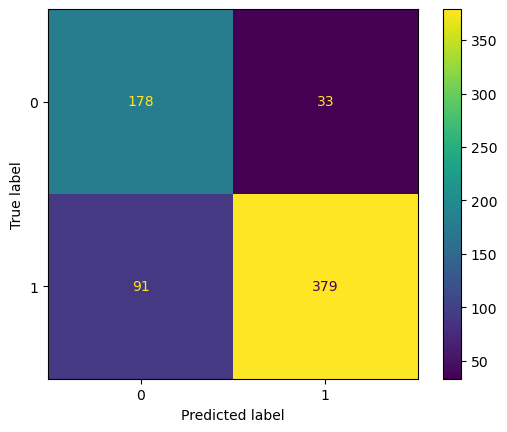

In [103]:
y_pred = model.predict(X_test)

acc = sklearn.metrics.accuracy_score(y_test, y_pred)
bacc = sklearn.metrics.balanced_accuracy_score(y_test, y_pred)
print(f'Accuracy          = {acc:.3f}')
print(f'Balanced Accuracy = {bacc:.3f}')

cm = sklearn.metrics.confusion_matrix(y_test, y_pred)
sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix=cm).plot()
plt.show()